这个notebook主要讨论 Background Subtraction Based on Low-Rank and Structured Sparse Decomposition这篇文章的背景建模方法

背景建模与语义分割semantic segmentation不同，主要是观察一些frames来建模出背景。除了pixel wise的平均值，差分，混合高斯之类的方法外。一种通用的套路显然是以某种模型拟合背景，然后把残差强的区域当作对象出现的区域。这就要求模型既不能太强也不能太弱。一种常见的背景模型就是低秩矩阵分解：

$$
D = L + S
$$

其中$D$为视频矩阵（n个frames已经被拉成m维列向量），$L$为背景矩阵，$S$为前景foreground，也就是对象覆盖北京的区域。显然通过要求背景矩阵低秩，相当于要求各个frames的背景列只能是可以被少数几个背景列混合/线性组合而成，而这就相当于一个类似混合高斯分布的设定。当然这里也没有考虑到区域之间的相关性，而只不过是以比混合高斯分布建模直接多的方式表示了一个事实。

为了约束前景，我们会试图让它稀疏，或者说不等于0的entries数量尽可能少，这个还比较直接。

于是也许我们会试图求解这么一个优化问题来达到目的：

$$
\begin{align*}
\min_{L,S}\, &  rank(L) + \lambda ||S||_0 \\
s.t. \, & D = L+S
\end{align*}
$$

显然这个函数不容易处理，比如连求导都不能，常见的作法是用nuclear norm $||L||_*$(核范数，即奇异值的和，即$L^*L$的特征值的和($*$指共轭转置而不是伴随矩阵))替换$rank(L)$。而用$||S||_1$替换$||S||_0$.除了它们也不是那么完全的可导性以外，主要在于它们是某种意义上的对那两个函数的最优凸近似。

https://www.zhihu.com/question/26471536/answer/53961085

这个问题提供了一些背景。

总之，问题变为：

$$
\begin{align*}
\min_{L,S}\, &  ||L||_* + \lambda ||S||_1 \\
s.t. \, & D = L+S
\end{align*}
$$

由于$D$是固定的，我们可以把约束拿掉，但那样就需要计算$||D-L||_1$或$||D-S||_*$之类的东西，不过目前来看也没什么困难。另外因为特征值的和为矩阵的trace，所以以下式可以直接计算nuclear norm吗

$$
||A||_* = trace(\sqrt{A^*A}) = \sum_{i=1}^{min(n,m)} \sigma_i(A)
$$

也许不能，$\sqrt{A}$是半正定矩阵上才有良定义的，所以我们也许还得用svd分解显示计算出奇异值后把它们加起来。不过也许我们只需要前几个奇异值.

In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import imageio

In [3]:
vid = imageio.get_reader('VID_20181126_221930.mp4',  'ffmpeg')
vid.get_length()

47

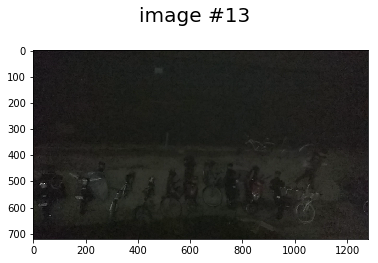

In [4]:
nums = [13]

for num in nums:
    image = vid.get_data(num)
    fig = plt.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    plt.imshow(image)
plt.show()


In [18]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
_frames = []
for i in range(vid.get_length()):
    _frames.append(rgb2gray(vid.get_data(i)))

In [19]:
frames = np.array(_frames)
frames.shape

(47, 720, 1280)

In [8]:
frame = frames[0]

In [12]:
a,b,c = np.linalg.svd(frame)

In [15]:
a.shape,b.shape,c.shape

((720, 720), (720,), (1280, 1280))

In [16]:
b.sum()

96155.03707478556

In [21]:
D = np.reshape(frames, (frames.shape[0],-1))

In [22]:
D.shape

(47, 921600)

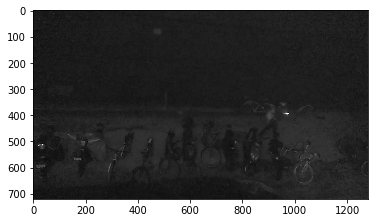

In [25]:
plt.imshow(D[0].reshape(frames[0].shape), cmap='gray')

其实这时候我们可以看看直接在视频上做svd式压缩是什么结果。

In [29]:
%%time
A,B,C = np.linalg.svd(D,full_matrices=False)

Wall time: 5.63 s


In [30]:
A.shape,B.shape,C.shape

((47, 47), (47,), (47, 921600))

In [32]:
D2=A[:,:10] @ np.diag(B[:10]) @ C[:10,:]

In [33]:
D2.shape

(47, 921600)

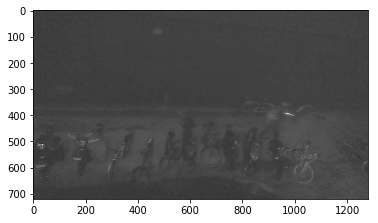

In [35]:
plt.imshow(D2[0].reshape(frames[0].shape),cmap='gray')

In [36]:
def save_seq(seq, tag):
    vid_writer = imageio.get_writer('VID_20181126_221930_'+ tag +'.mp4',  'ffmpeg')
    for i in range(seq.shape[0]):
        vid_writer.append_data(seq[i])
    vid_writer.close()

In [44]:
save_seq(((D2 - D2.min())/(D2.max()-D2.min()) * 256).astype(np.uint8).reshape((D2.shape[0],)+frames[0].shape),'rank10')

In [63]:
D3=A[:,:3] @ np.diag(B[:3]) @ C[:3,:]

In [49]:
del D2 # release RAN

In [64]:
D3.min(),D3.max()

(-50.18047350773923, 208.67182026311022)

In [65]:
D3=D3.clip(0,256)

In [66]:
D3=D3.astype(np.uint8).reshape((D3.shape[0],)+frames[0].shape)

In [67]:
save_seq(D3,'rank3')

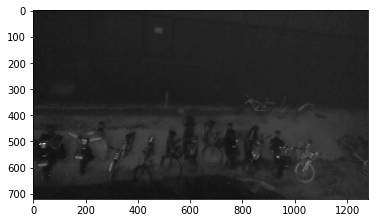

In [68]:
plt.imshow(D3[13],cmap='gray')

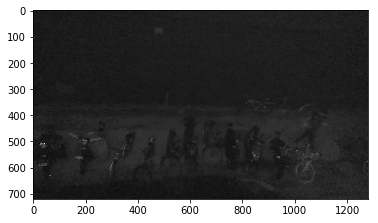

In [69]:
plt.imshow(frames[13],cmap='gray')

不难看出只使用3个奇异值恢复图像时，人基本已经消失，不过看视频则不可避免会看到一些鬼影现象。另外使用3个而非1个在视频中也可以看出起到了表示摄影的手机抖动的效果。

In [70]:
D3=A[:,:1] @ np.diag(B[:1]) @ C[:1,:]

In [71]:
D3=D3.clip(0,256)

In [72]:
D3=D3.astype(np.uint8).reshape((D3.shape[0],)+frames[0].shape)

In [73]:
save_seq(D3,'rank1')

不过只是计算出背景好像也没什么用，比如我们完全可以计算frames的中值来建模背景，如果我们只是再用它减去原视频，那和中值法好像也没什么区别。

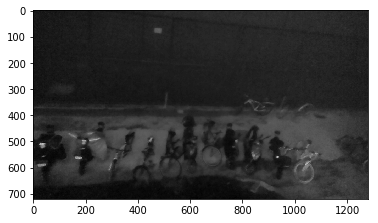

In [74]:
plt.imshow(np.median(frames,axis=0),cmap='gray')

In [76]:
np.abs(D).sum()

1376058490.8989985

In [77]:
B.sum()

368260.4182659707